In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, recall_score, roc_auc_score, precision_score, plot_confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier

pd.set_option('display.max_rows', 250)

In [2]:
df_ml_conso_balanced = pd.read_csv('../../datasets/3_ml_patients_consolidation/df_ml_conso_balanced.csv')
df_ml_conso_balanced.head()

,basSQI_score,cSQI_score,kSQI_score,pSQI_score,qSQI_score,sSQI_score,classification
0,0.83,0.60,6.17,0.50,0.57,-0.35,0
1,0.94,0.59,10.79,0.51,0.85,2.97,0
2,0.91,0.53,9.13,0.53,0.80,2.50,0
3,0.79,0.62,1.96,0.51,0.79,0.93,0
4,0.96,0.55,16.03,0.52,0.87,3.69,0


In [3]:
def make_performance_report(model, X_train, X_test, y_train, y_test):

    print('\nPerformance report :\n')
    # Feedback of the best model
    print('Best parameters:',model.best_params_)
    print('Score of best estimator on train:',model.best_estimator_.score(X_train, y_train))
    print('Score of best estimator on test:',model.best_estimator_.score(X_test, y_test))

    # Creation of the predictions of y_train & y_test

    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)


    # Output the accuracy and f1 score for the model
    print()
    print("Accuracy on train set :", accuracy_score(y_train, y_train_pred))
    print("Accuracy on test set :", accuracy_score(y_test, y_test_pred))
    print()

    print()
    print("f1-score on traina set :", f1_score(y_train, y_train_pred))
    print("f1-score on test set :", f1_score(y_test, y_test_pred))
    print()

    print()
    print("Recall on train set :", recall_score(y_train, y_train_pred))
    print("Recall on test set :", recall_score(y_test, y_test_pred))
    print()

    print()
    print("Precision on train set :", precision_score(y_train, y_train_pred))
    print("Precision on test set :", precision_score(y_test, y_test_pred))
    print()

    print()
    print("ROC_AUC_score on train set :", roc_auc_score(y_train, y_train_pred))
    print("ROC_AUC_score on test set :", roc_auc_score(y_test, y_test_pred))
    print()

    # Plot non-normalized confusion matrix
    titles_options = [("Confusion matrix, without normalization", None),
                    ("Normalized confusion matrix", 'true')]
    for title, normalize in titles_options:
        disp = plot_confusion_matrix(model, X_test, y_test,
                                    display_labels=[0,1],
                                    cmap=plt.cm.Blues,
                                    normalize=normalize)
        disp.ax_.set_title(title)

    plt.show()

# I - Preprocessing

In [4]:
df = df_ml_conso_balanced

# Declaration of target and features_list

target_variable = 'classification'
features_list = df.columns.drop(target_variable)

X = df.loc[:, features_list]
y = df.loc[:, target_variable]

# Distinction of categorical features
# (string values, columns index for numpy use)

categorical_features_str = (X.select_dtypes(include=['object']).columns)
categorical_features = [X.columns.get_loc(i) for i in categorical_features_str]

print('categorical columns:',categorical_features)

# Distinction of numeric features 

numeric_features_str = X.columns.drop(categorical_features_str)
numeric_features = [X.columns.get_loc(i) for i in numeric_features_str]

print('numeric columns:',numeric_features)

# Division of dataset Train set & Test set 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Convertion of pandas DataFrames to numpy arrays before using scikit-learn

X_train = X_train.values
X_test = X_test.values
y_train = y_train.values
y_test = y_test.values

print('Proportion of class 1 in y_train: ', np.mean(y_train))

print('Proportion of class 1 in y_test: ', np.mean(y_test))

# Declaration of the categorical and numeric transfomers

categorical_transformer = OneHotEncoder(drop='first')
numeric_transformer = StandardScaler()

# Declaration of the feature encoder

feature_encoder = ColumnTransformer(
transformers=[
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
]
)

# Fit of the encoder on X_train and transform of X_train

# Fit on X

feature_encoder.fit(X_train)

print('Shape before feature encoder:', X_train.shape)
X_train = feature_encoder.transform(X_train)
print('Shape after feature encoder:', X_train.shape)

# Transformation of X_test
X_test = feature_encoder.transform(X_test)

categorical columns: []
numeric columns: [0, 1, 2, 3, 4, 5]
Proportion of class 1 in y_train:  0.5
Proportion of class 1 in y_test:  0.5
Shape before feature encoder: (6292, 6)
Shape after feature encoder: (6292, 6)


# II - Logistic Regression

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 out of  40 | elapsed:    0.9s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  27 out of  40 | elapsed:    1.0s remaining:    0.5s
[Parallel(n_jobs=-1)]: Done  36 out of  40 | elapsed:    1.0s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  40 out of  40 | elapsed:    1.1s finished
GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'class_weight': [True, False],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['newton-cg']},
             scoring='recall', verbose=5)

Performance report :

Best parameters: {'class_weight': True, 'penalty': 'l2', 'solver': 'newton-cg'}
Score of best estimator on train: 0.817546090273363
Score of best estimator on test: 0.8024142312579415

Accuracy on train set : 0.817546090273363
Accuracy on test

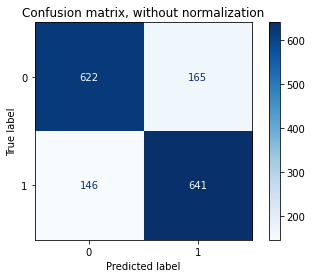

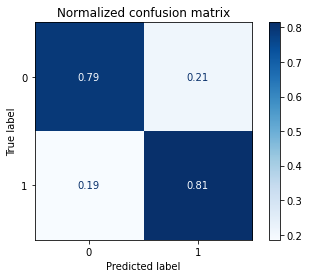

In [5]:
# Declaration of algorithm and parameters for gridsearch

algo = LogisticRegression()
params = {'class_weight' : [True, False],
          'solver' : ['newton-cg',],
          'penalty': ['l1', 'l2', 'elasticnet', 'none']
         }
grid_search_log = GridSearchCV(estimator=algo, param_grid= params, scoring='recall', cv = 5,verbose=5,n_jobs=-1)

# Fitting on train datas

grid_search_log.fit(X_train, y_train)
print(grid_search_log)
make_performance_report(grid_search_log , X_train, X_test, y_train, y_test)

# III - ML - Random Forest Regressor

In [6]:
# Declaration of algorithm and parameters for gridsearch

algo = RandomForestClassifier()
params = {'class_weight' : [None, 'balanced'],
          'min_samples_leaf' : np.arange(1,8,1),
         'max_depth' :  np.arange(1,8,1),
         'max_features' : np.arange(1,8,1),
         'n_estimators' : np.arange(1,8,1),
         # 'criterion' : ['gini', 'entropy']
         }

RanClassRecall =  GridSearchCV(estimator=algo, param_grid= params, scoring='recall', cv = 5,verbose=5,n_jobs=-1)
RanClassAcc =  GridSearchCV(estimator=algo, param_grid= params, scoring='accuracy', cv = 5,verbose=5,n_jobs=-1)
RanClassPrecision =  GridSearchCV(estimator=algo, param_grid= params, scoring='precision', cv = 5,verbose=5,n_jobs=-1)
RanClassF1 =  GridSearchCV(estimator=algo, param_grid= params, scoring='f1', cv = 5,verbose=5,n_jobs=-1)
RanClassRocAuc =  GridSearchCV(estimator=algo, param_grid= params, scoring='roc_auc', cv = 5,verbose=5,n_jobs=-1)

# grid_search_RFC_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_RFC_list = [RanClassRocAuc]

# Fitting on train datas

for grid_search in grid_search_RFC_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 4802 candidates, totalling 24010 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  48 tasks      | elapsed:    0.2s
[Parallel(n_jobs=-1)]: Done 496 tasks      | elapsed:    1.1s
[Parallel(n_jobs=-1)]: Done 1504 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 2800 tasks      | elapsed:    4.7s
[Parallel(n_jobs=-1)]: Done 4384 tasks      | elapsed:    7.3s
[Parallel(n_jobs=-1)]: Done 6256 tasks      | elapsed:   10.9s
[Parallel(n_jobs=-1)]: Done 8416 tasks      | elapsed:   15.1s
[Parallel(n_jobs=-1)]: Done 10864 tasks      | elapsed:   20.3s
[Parallel(n_jobs=-1)]: Done 13600 tasks      | elapsed:   25.4s
[Parallel(n_jobs=-1)]: Done 16624 tasks      | elapsed:   30.9s
[Parallel(n_jobs=-1)]: Done 19936 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 23536 tasks      | elapsed:   45.8s
[Parallel(n_jobs=-1)]: Done 24010 out of 24010 | elapsed:   46.7s finished


GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': [None, 'balanced'],
                         'max_depth': array([1, 2, 3, 4, 5, 6, 7]),
                         'max_features': array([1, 2, 3, 4, 5, 6, 7]),
                         'min_samples_leaf': array([1, 2, 3, 4, 5, 6, 7]),
                         'n_estimators': array([1, 2, 3, 4, 5, 6, 7])},
             scoring='roc_auc', verbose=5)

Performance report :

Best parameters: {'class_weight': None, 'max_depth': 7, 'max_features': 5, 'min_samples_leaf': 5, 'n_estimators': 7}
Score of best estimator on train: 0.8939923712650986
Score of best estimator on test: 0.8532401524777636

Accuracy on train set : 0.8939923712650986
Accuracy on test set : 0.8532401524777636


f1-score on traina set : 0.8967652066243615
f1-score on test set : 0.8576709796672829


Recall on train set : 0.9208518753973299
Recall on test set : 0.8843710292249047


Precision on train set : 0.8739064856711

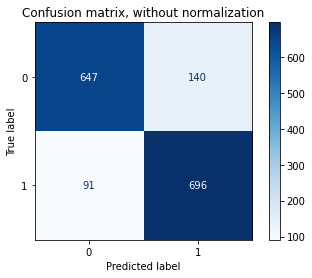

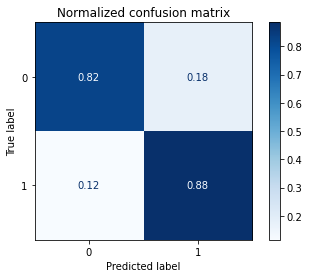

In [7]:
for grid_search in grid_search_RFC_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, X_test, y_train, y_test)

# IV - ML - XGBoost

In [8]:
# Declaration of algorithm and parameters for gridsearch

algo = XGBClassifier()
params = {'class_weight' : [None, 'balanced'],
          'min_samples_leaf' : np.arange(5,8,1),
          'max_depth' :  np.arange(5,8,1),
          'max_features' : np.arange(5,8,1),
          'n_estimators' : np.arange(5,8,1),
          # 'criterion' : ['gini', 'entropy']
          }

# params = {'class_weight': [None], 'max_depth': [7], 'max_features': [5], 'min_samples_leaf': [6], 'n_estimators': [7]}


XGBClassRecall =  GridSearchCV(estimator=algo, param_grid= params, scoring='recall', cv = 5,verbose=5,n_jobs=-1)
XGBClassAcc =  GridSearchCV(estimator=algo, param_grid= params, scoring='accuracy', cv = 5,verbose=5,n_jobs=-1)
XGBClassPrecision =  GridSearchCV(estimator=algo, param_grid= params, scoring='precision', cv = 5,verbose=5,n_jobs=-1)
XGBClassF1 =  GridSearchCV(estimator=algo, param_grid= params, scoring='f1', cv = 5,verbose=5,n_jobs=-1)
XGBClassRocAuc =  GridSearchCV(estimator=algo, param_grid= params, scoring='roc_auc', cv = 5,verbose=5,n_jobs=-1)

# grid_search_list = [RanClassRecall, RanClassAcc, RanClassPrecision, RanClassF1, RanClassRocAuc]

grid_search_XGB_list = [XGBClassRocAuc]

# Fitting on train datas

for grid_search in grid_search_XGB_list:
    grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 162 candidates, totalling 810 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  40 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 130 tasks      | elapsed:   29.1s
[Parallel(n_jobs=-1)]: Done 256 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 616 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 810 out of 810 | elapsed:  3.5min finished
[23:04:51] WARNING: ../src/learner.cc:541: 
Parameters: { max_features, min_samples_leaf } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[23:04:51] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'bin

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, gamma=None,
                                     gpu_id=None, importance_type='gain',
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs...
                                     num_parallel_tree=None, random_state=None,
                                     reg_alpha=None, reg_lambda=None,
                                     scale_pos_weight=None, subsample=None,
                                     tree_method=None, va

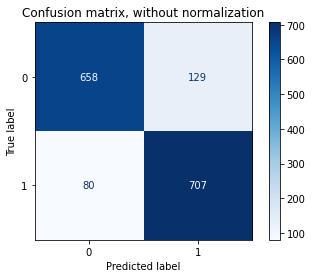

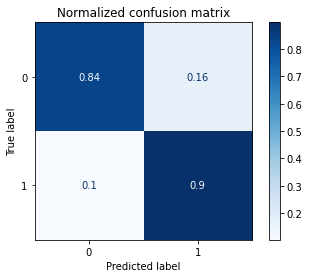

In [9]:
for grid_search in grid_search_XGB_list:
    print(grid_search)
    make_performance_report(grid_search , X_train, X_test, y_train, y_test)

# V - Export of models

In [10]:
# dump feature encoder
dump(feature_encoder, '../../data/data_encoder/data_encoder.joblib')

# dump RandomForestClassifier model
dump(grid_search_RFC_list[0], '../../data/models/xgb.joblib')

# dump XGBoostClassifier model
dump(grid_search_XGB_list[0], '../../data/models/xgb.joblib')

['../../data/models/xgb.joblib']